In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import csv
import pickle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **Data Loading**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ***Information***
Attribute Information.
  1.  Sequence Name: Accession number for the SWISS-PROT database
  2.  mcg: McGeoch's method for signal sequence recognition.
  3.  gvh: von Heijne's method for signal sequence recognition.
  4.  alm: Score of the ALOM membrane spanning region prediction program.
  5.  mit: Score of discriminant analysis of the amino acid content of
	   the N-terminal region (20 residues long) of mitochondrial and 
           non-mitochondrial proteins.
  6.  erl: Presence of "HDEL" substring (thought to act as a signal for
	   retention in the endoplasmic reticulum lumen). Binary attribute.
  7.  pox: Peroxisomal targeting signal in the C-terminus.
  8.  vac: Score of discriminant analysis of the amino acid content of
           vacuolar and extracellular proteins.
  9.  nuc: Score of discriminant analysis of nuclear localization signals
	   of nuclear and non-nuclear proteins.


Class Distribution. The class is the localization site. Please see Nakai &
Kanehisa referenced above for more details.
  

  1.  CYT (cytosolic or cytoskeletal)                    463
  2.  NUC (nuclear)                                      429
  3.  MIT (mitochondrial)                                244
  4.  ME3 (membrane protein, no N-terminal signal)       163
  5.  ME2 (membrane protein, uncleaved signal)            51
  6.  ME1 (membrane protein, cleaved signal)              44
  7.  EXC (extracellular)                                 37
  8.  VAC (vacuolar)                                      30
  9.  POX (peroxisomal)                                   20
  10. ERL (endoplasmic reticulum lumen)                    5



In [4]:
dataSet = 'yeast_5'
filePath = '/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_5/'+dataSet+'.csv'
data = pd.read_csv(filePath)
data

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,ME2
1480,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,ME2
1482,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


In [5]:
data.groupby('name').count()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
name,,,,,,,,
CYT,463,463,463,463,463,463,463,463
ERL,5,5,5,5,5,5,5,5
EXC,35,35,35,35,35,35,35,35
ME1,44,44,44,44,44,44,44,44
ME2,51,51,51,51,51,51,51,51
ME3,163,163,163,163,163,163,163,163
MIT,244,244,244,244,244,244,244,244
NUC,429,429,429,429,429,429,429,429
POX,20,20,20,20,20,20,20,20


In [6]:
data = data.replace(np.nan,0.0)

In [7]:
data.iloc[3,3]

0.13

In [8]:
for i in range(len(data)):
  if data.iloc[i,8]=='ME3':
    data.iloc[i,8] = 1.0
  else:
    data.iloc[i,8] = 0.0
data

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,0.0
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,0.0
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,0.0
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,0.0
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,0.0
...,...,...,...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,0.0
1480,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,0.0
1481,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,0.0
1482,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,0.0


In [9]:
from random import shuffle
train, test= train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
print(train.shape,test.shape)

(1187, 9) (297, 9)


In [10]:
train.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
381,0.31,0.45,0.50,0.17,0.5,0.0,0.49,0.22,0.0
532,0.50,0.45,0.48,0.17,0.5,0.0,0.50,0.26,0.0
674,0.50,0.36,0.53,0.41,0.5,0.0,0.55,0.36,0.0
482,0.70,0.73,0.37,0.37,0.5,0.0,0.48,0.31,0.0
405,0.44,0.42,0.62,0.14,0.5,0.0,0.55,0.37,0.0


In [11]:
features = train.columns[0:-1]
features

Index(['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc'], dtype='object')

In [12]:
X = data[features]
y = data['name']
X

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22
...,...,...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22
1480,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47
1481,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22
1482,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39


# **Data Split (Major and Minor)**

In [14]:
for(name), group in train.groupby(['name']):
  group.to_csv(f'{name}.csv', index=False)
# print(pd.read_csv("0.0.csv"))
# print(pd.read_csv("1.0.csv"))
train_zero = pd.read_csv("0.0.csv")
train_one = pd.read_csv("1.0.csv")
train_zero

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.31,0.45,0.50,0.17,0.5,0.0,0.49,0.22,0.0
1,0.50,0.45,0.48,0.17,0.5,0.0,0.50,0.26,0.0
2,0.50,0.36,0.53,0.41,0.5,0.0,0.55,0.36,0.0
3,0.70,0.73,0.37,0.37,0.5,0.0,0.48,0.31,0.0
4,0.44,0.42,0.62,0.14,0.5,0.0,0.55,0.37,0.0
...,...,...,...,...,...,...,...,...,...
1053,0.45,0.41,0.53,0.49,0.5,0.0,0.49,0.31,0.0
1054,0.45,0.76,0.51,0.25,0.5,0.0,0.59,0.22,0.0
1055,0.45,0.53,0.51,0.42,0.5,0.0,0.52,0.22,0.0
1056,0.41,0.45,0.46,0.23,0.5,0.0,0.50,0.70,0.0


In [15]:
train_one

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.39,0.44,0.28,0.12,0.5,0.0,0.46,0.27,1.0
1,0.39,0.44,0.35,0.16,0.5,0.0,0.55,0.22,1.0
2,0.32,0.45,0.39,0.14,0.5,0.0,0.45,0.22,1.0
3,0.47,0.54,0.37,0.14,0.5,0.0,0.50,0.22,1.0
4,0.51,0.47,0.41,0.44,0.5,0.0,0.50,0.22,1.0
...,...,...,...,...,...,...,...,...,...
124,0.35,0.53,0.35,0.33,0.5,0.0,0.50,0.32,1.0
125,0.25,0.42,0.21,0.14,0.5,0.0,0.41,0.22,1.0
126,0.37,0.40,0.38,0.18,0.5,0.0,0.51,0.22,1.0
127,0.37,0.34,0.32,0.22,0.5,0.0,0.56,0.22,1.0


In [16]:
train_zero.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_5/train_zero.csv')
train_one.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_5/train_one.csv')


In [17]:
major_class = train_zero
minor_class = train_one

In [18]:
# before scaling the min and max values for both alcohol and malic acid are different 

minor_class.describe().T  


,count,mean,std,min,25%,50%,75%,max
mcg,129.0,0.430155,0.098051,0.20,0.36,0.43,0.50,0.67
gvh,129.0,0.491705,0.116580,0.14,0.42,0.49,0.58,0.81
alm,129.0,0.363566,0.057320,0.21,0.33,0.36,0.40,0.50
mit,129.0,0.212791,0.074278,0.08,0.16,0.20,0.26,0.47
erl,129.0,0.503876,0.044023,0.50,0.50,0.50,0.50,1.00
pox,129.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
vac,129.0,0.508140,0.036137,0.39,0.49,0.51,0.53,0.57
nuc,129.0,0.265969,0.086571,0.22,0.22,0.22,0.29,0.83
name,129.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.00


In [19]:
major_class.describe().T

,count,mean,std,min,25%,50%,75%,max
mcg,1058.0,0.510435,0.139045,0.11,0.41,0.49,0.58,0.97
gvh,1058.0,0.500841,0.125043,0.16,0.42,0.49,0.57,1.00
alm,1058.0,0.517089,0.075783,0.26,0.48,0.52,0.56,1.00
mit,1058.0,0.268573,0.141489,0.00,0.17,0.22,0.34,1.00
erl,1058.0,0.505198,0.050741,0.50,0.50,0.50,0.50,1.00
pox,1058.0,0.008951,0.082047,0.00,0.00,0.00,0.00,0.83
vac,1058.0,0.497864,0.060449,0.00,0.48,0.51,0.53,0.73
nuc,1058.0,0.274319,0.105895,0.00,0.22,0.22,0.30,1.00
name,1058.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00


In [20]:
n = len(data.iloc[0])
n

9

# **Auto Encoder**

In [21]:
import keras
from keras import layers

# This is the size of our encoded representations
n = len(data.iloc[0]) - 1
encoding_dim = n # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(n,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation=None)(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(n, activation=None)(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [22]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


In [23]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [24]:
autoencoder.compile(optimizer='adam', loss='mse')

In [25]:
x_train = minor_class[features]
x_test = major_class[features]
y_train = minor_class['name']
y_test = major_class['name']

# **Data Scaling**

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()    # create an object of class

scaler.fit(x_train)       #  fit on training i/p data
x_train_scaled = scaler.transform(x_train)    # transform model on both traing and testing data

scaler.fit(x_test)
x_test_scaled = scaler.transform(x_test)


In [27]:
# convert the numpy array after transform into a dataframe
x_train_scaled = pd.DataFrame(x_train_scaled,columns = x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled,columns = x_test.columns)
#x_test_scaled = pd.DataFrame(x_test_scaled,columns = x_test.columns)


In [28]:
x_train.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_5/x_train.csv')
x_test.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_5/x_test.csv')
x_train_scaled.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_5/x_train_scaled.csv')
x_test_scaled.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_5/x_test_scaled.csv')


In [29]:
x_train.shape

(129, 8)

In [30]:
x_test.shape

(1058, 8)

In [31]:
x_train

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.39,0.44,0.28,0.12,0.5,0.0,0.46,0.27
1,0.39,0.44,0.35,0.16,0.5,0.0,0.55,0.22
2,0.32,0.45,0.39,0.14,0.5,0.0,0.45,0.22
3,0.47,0.54,0.37,0.14,0.5,0.0,0.50,0.22
4,0.51,0.47,0.41,0.44,0.5,0.0,0.50,0.22
...,...,...,...,...,...,...,...,...
124,0.35,0.53,0.35,0.33,0.5,0.0,0.50,0.32
125,0.25,0.42,0.21,0.14,0.5,0.0,0.41,0.22
126,0.37,0.40,0.38,0.18,0.5,0.0,0.51,0.22
127,0.37,0.34,0.32,0.22,0.5,0.0,0.56,0.22


In [32]:
x_test

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.31,0.45,0.50,0.17,0.5,0.0,0.49,0.22
1,0.50,0.45,0.48,0.17,0.5,0.0,0.50,0.26
2,0.50,0.36,0.53,0.41,0.5,0.0,0.55,0.36
3,0.70,0.73,0.37,0.37,0.5,0.0,0.48,0.31
4,0.44,0.42,0.62,0.14,0.5,0.0,0.55,0.37
...,...,...,...,...,...,...,...,...
1053,0.45,0.41,0.53,0.49,0.5,0.0,0.49,0.31
1054,0.45,0.76,0.51,0.25,0.5,0.0,0.59,0.22
1055,0.45,0.53,0.51,0.42,0.5,0.0,0.52,0.22
1056,0.41,0.45,0.46,0.23,0.5,0.0,0.50,0.70


In [33]:
x_train_scaled

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.404255,0.447761,0.241379,0.102564,0.0,0.0,0.388889,0.081967
1,0.404255,0.447761,0.482759,0.205128,0.0,0.0,0.888889,0.000000
2,0.255319,0.462687,0.620690,0.153846,0.0,0.0,0.333333,0.000000
3,0.574468,0.597015,0.551724,0.153846,0.0,0.0,0.611111,0.000000
4,0.659574,0.492537,0.689655,0.923077,0.0,0.0,0.611111,0.000000
...,...,...,...,...,...,...,...,...
124,0.319149,0.582090,0.482759,0.641026,0.0,0.0,0.611111,0.163934
125,0.106383,0.417910,0.000000,0.153846,0.0,0.0,0.111111,0.000000
126,0.361702,0.388060,0.586207,0.256410,0.0,0.0,0.666667,0.000000
127,0.361702,0.298507,0.379310,0.358974,0.0,0.0,0.944444,0.000000


In [34]:
x_test_scaled

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.232558,0.345238,0.324324,0.17,0.0,0.0,0.671233,0.22
1,0.453488,0.345238,0.297297,0.17,0.0,0.0,0.684932,0.26
2,0.453488,0.238095,0.364865,0.41,0.0,0.0,0.753425,0.36
3,0.686047,0.678571,0.148649,0.37,0.0,0.0,0.657534,0.31
4,0.383721,0.309524,0.486486,0.14,0.0,0.0,0.753425,0.37
...,...,...,...,...,...,...,...,...
1053,0.395349,0.297619,0.364865,0.49,0.0,0.0,0.671233,0.31
1054,0.395349,0.714286,0.337838,0.25,0.0,0.0,0.808219,0.22
1055,0.395349,0.440476,0.337838,0.42,0.0,0.0,0.712329,0.22
1056,0.348837,0.345238,0.270270,0.23,0.0,0.0,0.684932,0.70


In [35]:
autoencoder.fit(x_train_scaled, x_train_scaled,
                epochs=50,
                batch_size=8,
                shuffle=True,
                validation_data=(x_train_scaled, x_train_scaled))

Epoch 1/50
17/17 [==============================] - 1s 13ms/step - loss: 0.2869 - val_loss: 0.2496
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: 0.2257 - val_loss: 0.1990
Epoch 3/50
17/17 [==============================] - 0s 4ms/step - loss: 0.1811 - val_loss: 0.1597
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.1452 - val_loss: 0.1281
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 0.1160 - val_loss: 0.1017
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0918 - val_loss: 0.0799
Epoch 7/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0722 - val_loss: 0.0633
Epoch 8/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0577 - val_loss: 0.0509
Epoch 9/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0469 - val_loss: 0.0426
Epoch 10/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0401 - val_loss: 0.0374
Epoch 11/50
17/17 

In [36]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test_scaled)
#decoded_imgs = decoder.predict(encoded_imgs)
encoded_imgs

34/34 [==============================] - 0s 1ms/step


array([[ 0.23934114,  0.08378363,  0.4464994 , ..., -0.5842542 ,
         0.2614846 , -0.13148114],
       [ 0.15959418,  0.06619564,  0.5467772 , ..., -0.5043813 ,
         0.18439636, -0.14519796],
       [ 0.13170043,  0.24557617,  0.76442724, ..., -0.44546905,
         0.22238006, -0.05453587],
       ...,
       [ 0.14898494,  0.21159776,  0.6800857 , ..., -0.57501864,
         0.350031  , -0.18952234],
       [ 0.10181981,  0.09118125,  0.714904  , ..., -0.5866326 ,
        -0.01348369,  0.08070917],
       [ 0.02143139,  0.07004648,  0.65039486, ..., -0.36801168,
         0.2793301 , -0.10114088]], dtype=float32)

# **Euclidean Distance**

In [37]:
x_test_scaled_euclidean = x_test_scaled
x_test_scaled_euclidean.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_5/x_test_scaled_euclidean.csv')
x_test_scaled_euclidean

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.232558,0.345238,0.324324,0.17,0.0,0.0,0.671233,0.22
1,0.453488,0.345238,0.297297,0.17,0.0,0.0,0.684932,0.26
2,0.453488,0.238095,0.364865,0.41,0.0,0.0,0.753425,0.36
3,0.686047,0.678571,0.148649,0.37,0.0,0.0,0.657534,0.31
4,0.383721,0.309524,0.486486,0.14,0.0,0.0,0.753425,0.37
...,...,...,...,...,...,...,...,...
1053,0.395349,0.297619,0.364865,0.49,0.0,0.0,0.671233,0.31
1054,0.395349,0.714286,0.337838,0.25,0.0,0.0,0.808219,0.22
1055,0.395349,0.440476,0.337838,0.42,0.0,0.0,0.712329,0.22
1056,0.348837,0.345238,0.270270,0.23,0.0,0.0,0.684932,0.70


In [38]:
new_col = []
#print(len(x_test_scaled.iloc[0]))
for i in range(len(x_test_scaled)):
  tot = 0
  for j in range(len(x_test_scaled.iloc[i])):
    a = (x_test_scaled.iloc[i,j] - encoded_imgs[i][j])*(x_test_scaled.iloc[i,j] - encoded_imgs[i][j])
    tot = tot + a
  new_col.append(tot)
#print(len(new_col))
new_col

[0.8610339478797178,
 1.0823282475331375,
 1.3483287022415698,
 2.443950155547742,
 1.083944976828429,
 0.7398763750696598,
 0.9138870864952987,
 2.8461039726486406,
 0.5689148944245966,
 1.8124715543835639,
 1.6874112986957794,
 1.3741632619842707,
 0.8816467048104524,
 0.952137067771787,
 1.262302265261106,
 1.9541053382612128,
 1.8552123394737008,
 1.1623637523772847,
 1.1216798380321944,
 1.6530597911728804,
 0.8419157297028658,
 1.1892969930584765,
 2.071300963849617,
 1.1698319335029923,
 1.0993220448045968,
 1.637308716129093,
 1.4170765388325957,
 0.7638743093483615,
 1.1364670823548244,
 2.1540941179618214,
 0.5183364787074239,
 1.2602777185011538,
 2.665498187110001,
 1.386098418176824,
 2.3501864073125858,
 0.7654327230725343,
 1.310198382183369,
 1.2831649564139345,
 1.6838815620246355,
 1.394673299365565,
 2.165063522860679,
 1.405662504498389,
 1.176448793202626,
 1.4013524028696496,
 1.091431084888004,
 1.3949351158024763,
 1.018338121943747,
 1.9983398317975645,
 1.6394

In [39]:
x_test_scaled_euclidean['euclidean_distance'] = new_col
#x_test_scaled_euclidean = x_test_scaled_euclidean.drop(['Unnamed: 0'], axis=1)
x_test_scaled_euclidean.to_csv('x_test_scaled_euclidean.csv')
x_test_scaled_euclidean

,mcg,gvh,alm,mit,erl,pox,vac,nuc,euclidean_distance
0,0.232558,0.345238,0.324324,0.17,0.0,0.0,0.671233,0.22,0.861034
1,0.453488,0.345238,0.297297,0.17,0.0,0.0,0.684932,0.26,1.082328
2,0.453488,0.238095,0.364865,0.41,0.0,0.0,0.753425,0.36,1.348329
3,0.686047,0.678571,0.148649,0.37,0.0,0.0,0.657534,0.31,2.443950
4,0.383721,0.309524,0.486486,0.14,0.0,0.0,0.753425,0.37,1.083945
...,...,...,...,...,...,...,...,...,...
1053,0.395349,0.297619,0.364865,0.49,0.0,0.0,0.671233,0.31,1.241648
1054,0.395349,0.714286,0.337838,0.25,0.0,0.0,0.808219,0.22,1.944703
1055,0.395349,0.440476,0.337838,0.42,0.0,0.0,0.712329,0.22,1.278361
1056,0.348837,0.345238,0.270270,0.23,0.0,0.0,0.684932,0.70,1.714050


# **Sorting Data Based on Euclidean Distance**

In [41]:
# importing pandas package
import pandas as pandasForSortingCSV
# assign dataset
csvData = x_test_scaled_euclidean
# displaying unsorted data frame
print("\nBefore sorting:")
csvData
# sort data frame
csvData.sort_values(csvData.columns[n], axis=0, ascending=[False], inplace=True)
# displaying sorted data frame
print("\nAfter sorting:")
csvData


Before sorting:

After sorting:


,mcg,gvh,alm,mit,erl,pox,vac,nuc,euclidean_distance
736,0.906977,0.773810,0.135135,0.71,0.0,0.0,0.753425,0.63,4.763114
406,0.651163,0.547619,0.189189,0.43,0.0,1.0,0.684932,0.22,4.443715
658,0.534884,0.428571,0.270270,0.20,0.0,1.0,0.712329,0.41,4.168387
262,0.674419,0.523810,0.337838,0.13,0.0,1.0,0.712329,0.22,4.152172
226,0.662791,0.500000,0.337838,0.19,0.0,1.0,0.739726,0.22,4.146556
...,...,...,...,...,...,...,...,...,...
990,0.360465,0.178571,0.486486,0.12,0.0,0.0,0.547945,0.22,0.522539
265,0.081395,0.380952,0.270270,0.12,0.0,0.0,0.000000,0.25,0.519612
30,0.290698,0.250000,0.500000,0.25,0.0,0.0,0.410959,0.22,0.518336
271,0.267442,0.238095,0.378378,0.11,0.0,0.0,0.493151,0.21,0.485289


# **NUS1 Data**

In [42]:
final_data_without_euclidean = csvData.iloc[0:len(minor_class)]
final_data_without_euclidean = final_data_without_euclidean.drop(['euclidean_distance'], axis=1)
final_data_without_euclidean

,mcg,gvh,alm,mit,erl,pox,vac,nuc
736,0.906977,0.773810,0.135135,0.71,0.0,0.0,0.753425,0.63
406,0.651163,0.547619,0.189189,0.43,0.0,1.0,0.684932,0.22
658,0.534884,0.428571,0.270270,0.20,0.0,1.0,0.712329,0.41
262,0.674419,0.523810,0.337838,0.13,0.0,1.0,0.712329,0.22
226,0.662791,0.500000,0.337838,0.19,0.0,1.0,0.739726,0.22
...,...,...,...,...,...,...,...,...
797,0.825581,0.559524,0.283784,0.18,0.0,0.0,0.684932,0.22
103,0.744186,0.595238,0.513514,0.39,0.0,0.0,0.630137,0.32
266,0.732558,0.476190,0.121622,0.36,0.0,0.0,0.698630,0.25
373,0.581395,0.666667,0.175676,0.33,0.0,0.0,0.794521,0.22


In [43]:
data_with_nus1 = x_train_scaled
data_without_nus1 = x_train_scaled
data_with_nus1

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.404255,0.447761,0.241379,0.102564,0.0,0.0,0.388889,0.081967
1,0.404255,0.447761,0.482759,0.205128,0.0,0.0,0.888889,0.000000
2,0.255319,0.462687,0.620690,0.153846,0.0,0.0,0.333333,0.000000
3,0.574468,0.597015,0.551724,0.153846,0.0,0.0,0.611111,0.000000
4,0.659574,0.492537,0.689655,0.923077,0.0,0.0,0.611111,0.000000
...,...,...,...,...,...,...,...,...
124,0.319149,0.582090,0.482759,0.641026,0.0,0.0,0.611111,0.163934
125,0.106383,0.417910,0.000000,0.153846,0.0,0.0,0.111111,0.000000
126,0.361702,0.388060,0.586207,0.256410,0.0,0.0,0.666667,0.000000
127,0.361702,0.298507,0.379310,0.358974,0.0,0.0,0.944444,0.000000


In [44]:
new_one = np.ones(len(final_data_without_euclidean))   #Adding target column in nus1
#final_data_without_euclidean
final_data_without_euclidean['target'] = new_one
#final_data_without_euclidean = final_data_without_euclidean.drop(['Unnamed: 0'], axis=1)
final_data_without_euclidean.to_csv('final_data_without_euclidean.csv')
final_data_without_euclidean

new_zero = np.zeros(len(data_with_nus1))      #Adding target column in minor class
data_with_nus1['target'] = new_zero
data_with_nus1.to_csv('data_with_nus1.csv')
data_with_nus1


#NUS1 data
nus1 = pd.concat(map(pd.read_csv, ['final_data_without_euclidean.csv', 'data_with_nus1.csv']), ignore_index=True)
nus1 = nus1.drop(['Unnamed: 0'], axis=1)
nus1.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_5/nus1.csv')
nus1

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
0,0.906977,0.773810,0.135135,0.710000,0.0,0.0,0.753425,0.630000,1.0
1,0.651163,0.547619,0.189189,0.430000,0.0,1.0,0.684932,0.220000,1.0
2,0.534884,0.428571,0.270270,0.200000,0.0,1.0,0.712329,0.410000,1.0
3,0.674419,0.523810,0.337838,0.130000,0.0,1.0,0.712329,0.220000,1.0
4,0.662791,0.500000,0.337838,0.190000,0.0,1.0,0.739726,0.220000,1.0
...,...,...,...,...,...,...,...,...,...
253,0.319149,0.582090,0.482759,0.641026,0.0,0.0,0.611111,0.163934,0.0
254,0.106383,0.417910,0.000000,0.153846,0.0,0.0,0.111111,0.000000,0.0
255,0.361702,0.388060,0.586207,0.256410,0.0,0.0,0.666667,0.000000,0.0
256,0.361702,0.298507,0.379310,0.358974,0.0,0.0,0.944444,0.000000,0.0


# **Original Data (Without NUS1)**

In [45]:
final_data_org_without_euclidean = csvData
final_data_org_without_euclidean = final_data_org_without_euclidean.drop(['euclidean_distance'], axis=1)
final_data_org_without_euclidean

,mcg,gvh,alm,mit,erl,pox,vac,nuc
736,0.906977,0.773810,0.135135,0.71,0.0,0.0,0.753425,0.63
406,0.651163,0.547619,0.189189,0.43,0.0,1.0,0.684932,0.22
658,0.534884,0.428571,0.270270,0.20,0.0,1.0,0.712329,0.41
262,0.674419,0.523810,0.337838,0.13,0.0,1.0,0.712329,0.22
226,0.662791,0.500000,0.337838,0.19,0.0,1.0,0.739726,0.22
...,...,...,...,...,...,...,...,...
990,0.360465,0.178571,0.486486,0.12,0.0,0.0,0.547945,0.22
265,0.081395,0.380952,0.270270,0.12,0.0,0.0,0.000000,0.25
30,0.290698,0.250000,0.500000,0.25,0.0,0.0,0.410959,0.22
271,0.267442,0.238095,0.378378,0.11,0.0,0.0,0.493151,0.21


In [46]:
data_with_nus1_org = x_train_scaled
data_without_nus1_org = x_train_scaled
data_with_nus1_org

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
0,0.404255,0.447761,0.241379,0.102564,0.0,0.0,0.388889,0.081967,0.0
1,0.404255,0.447761,0.482759,0.205128,0.0,0.0,0.888889,0.000000,0.0
2,0.255319,0.462687,0.620690,0.153846,0.0,0.0,0.333333,0.000000,0.0
3,0.574468,0.597015,0.551724,0.153846,0.0,0.0,0.611111,0.000000,0.0
4,0.659574,0.492537,0.689655,0.923077,0.0,0.0,0.611111,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
124,0.319149,0.582090,0.482759,0.641026,0.0,0.0,0.611111,0.163934,0.0
125,0.106383,0.417910,0.000000,0.153846,0.0,0.0,0.111111,0.000000,0.0
126,0.361702,0.388060,0.586207,0.256410,0.0,0.0,0.666667,0.000000,0.0
127,0.361702,0.298507,0.379310,0.358974,0.0,0.0,0.944444,0.000000,0.0


In [47]:
new_one_org = np.ones(len(final_data_org_without_euclidean))   #Adding target column in nus1
#final_data_without_euclidean
final_data_org_without_euclidean['target'] = new_one_org
#final_data_without_euclidean = final_data_without_euclidean.drop(['Unnamed: 0'], axis=1)
final_data_org_without_euclidean.to_csv('final_data_org_without_euclidean.csv')
final_data_org_without_euclidean

new_zero_org = np.zeros(len(data_with_nus1_org))      #Adding target column in minor class
data_with_nus1_org['target'] = new_zero
data_with_nus1_org.to_csv('data_with_nus1_org.csv')
data_with_nus1_org


#NUS1 data
nus1_orgg = pd.concat(map(pd.read_csv, ['final_data_org_without_euclidean.csv', 'data_with_nus1_org.csv']), ignore_index=True)
nus1_orgg = nus1_orgg.drop(['Unnamed: 0'], axis=1)
nus1_orgg.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_5/nus1_orgg.csv')
nus1_orgg

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
0,0.906977,0.773810,0.135135,0.710000,0.0,0.0,0.753425,0.630000,1.0
1,0.651163,0.547619,0.189189,0.430000,0.0,1.0,0.684932,0.220000,1.0
2,0.534884,0.428571,0.270270,0.200000,0.0,1.0,0.712329,0.410000,1.0
3,0.674419,0.523810,0.337838,0.130000,0.0,1.0,0.712329,0.220000,1.0
4,0.662791,0.500000,0.337838,0.190000,0.0,1.0,0.739726,0.220000,1.0
...,...,...,...,...,...,...,...,...,...
1182,0.319149,0.582090,0.482759,0.641026,0.0,0.0,0.611111,0.163934,0.0
1183,0.106383,0.417910,0.000000,0.153846,0.0,0.0,0.111111,0.000000,0.0
1184,0.361702,0.388060,0.586207,0.256410,0.0,0.0,0.666667,0.000000,0.0
1185,0.361702,0.298507,0.379310,0.358974,0.0,0.0,0.944444,0.000000,0.0


# **Test Data**

In [52]:
scaler.fit(test)
test_scaled = scaler.transform(test)
# convert the numpy array after transform into a dataframe
test_scaled = pd.DataFrame(test_scaled,columns = test.columns)
test_scaled.rename(columns = {'name':'target'}, inplace = True)
test.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_5/test.csv')
test_scaled.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_5/test_scaled.csv')
test_scaled

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
0,0.493827,0.618421,0.509434,0.493506,0.0,0.0,0.673469,0.227273,0.0
1,0.320988,0.565789,0.547170,0.766234,0.0,0.0,0.693878,0.125000,0.0
2,0.469136,0.486842,0.339623,0.038961,0.0,0.0,0.551020,0.125000,1.0
3,0.419753,0.407895,0.471698,0.220779,0.0,0.0,0.673469,0.125000,0.0
4,0.234568,0.315789,0.264151,0.116883,0.0,0.0,0.693878,0.125000,1.0
...,...,...,...,...,...,...,...,...,...
292,0.160494,0.618421,0.490566,0.103896,0.0,0.0,0.673469,0.125000,0.0
293,0.469136,0.302632,0.547170,0.259740,0.0,0.0,0.693878,0.159091,0.0
294,0.172840,0.315789,0.603774,0.298701,0.0,0.0,0.673469,0.181818,0.0
295,0.493827,0.710526,0.603774,0.181818,0.0,0.0,0.571429,0.556818,0.0


In [53]:
#from random import shuffle
#nus1 = shuffle(nus1)
nus1 = nus1.sample(frac=1)
nus1

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
250,0.723404,0.611940,0.724138,0.358974,0.0,0.0,0.500000,0.000000,0.0
137,0.659574,0.358209,0.724138,0.333333,0.0,0.0,0.388889,0.196721,0.0
198,0.340426,0.283582,0.586207,0.179487,0.0,0.0,0.888889,0.229508,0.0
185,0.297872,0.417910,0.310345,0.384615,0.0,0.0,0.777778,0.000000,0.0
109,0.372093,0.797619,0.391892,0.200000,0.0,0.0,0.643836,0.400000,1.0
...,...,...,...,...,...,...,...,...,...
82,0.779070,0.583333,0.189189,0.160000,0.0,0.0,0.863014,0.220000,1.0
9,0.860465,0.821429,0.054054,0.310000,0.0,0.0,0.753425,0.420000,1.0
157,0.531915,0.537313,0.758621,0.205128,0.0,0.0,0.722222,0.098361,0.0
6,0.569767,0.416667,0.459459,0.380000,0.0,1.0,0.712329,0.240000,1.0


In [54]:
# nus1_org = nus1_org.sample(frac=1)
# nus1_org

nus1_orgg = nus1_orgg.sample(frac=1)
nus1_orgg

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
828,0.267442,0.095238,0.337838,0.150000,0.0,0.0,0.739726,0.40,1.0
785,0.406977,0.261905,0.283784,0.220000,0.0,0.0,0.712329,0.27,1.0
545,0.406977,0.488095,0.418919,0.150000,0.0,0.0,0.712329,0.26,1.0
977,0.244186,0.214286,0.472973,0.170000,0.0,0.0,0.712329,0.32,1.0
583,0.604651,0.321429,0.297297,0.110000,0.0,0.0,0.698630,0.22,1.0
...,...,...,...,...,...,...,...,...,...
216,0.348837,0.107143,0.445946,0.440000,0.0,0.0,0.821918,0.69,1.0
1147,0.957447,0.716418,0.172414,0.641026,0.0,0.0,0.888889,0.00,0.0
1012,0.279070,0.428571,0.297297,0.220000,0.0,0.0,0.356164,0.22,1.0
255,0.395349,0.238095,0.324324,0.190000,0.0,0.0,0.726027,0.70,1.0


# **Classifier**

In [55]:
from sklearn.neighbors import KNeighborsClassifier
nus1_X_train = nus1[features]
nus1_y_train = nus1['target']

nus1_org_X_train = nus1_orgg[features]
nus1_org_y_train = nus1_orgg['target']

nus1_X_test = test_scaled[features]
nus1_y_test = test_scaled['target']

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(nus1_X_train, nus1_y_train)
print('NUS1 Data')
y_pred_nus1 = knn.predict(nus1_X_test)
print(y_pred_nus1)

#knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(nus1_org_X_train, nus1_org_y_train)
print('Without NUS1')
y_pred_org = knn.predict(nus1_X_test)
print(y_pred_org)

NUS1 Data
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0.]
Without NUS1
[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.

# **Confusion Matrix**

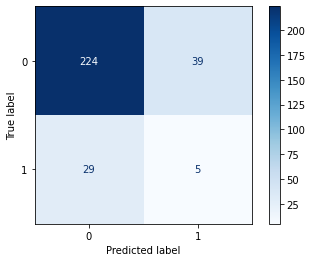

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

label = ["0", "1"]
cm = confusion_matrix(nus1_y_test, y_pred_nus1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [57]:
test_scaled.groupby('target').count()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
target,,,,,,,,
0.0,263,263,263,263,263,263,263,263
1.0,34,34,34,34,34,34,34,34


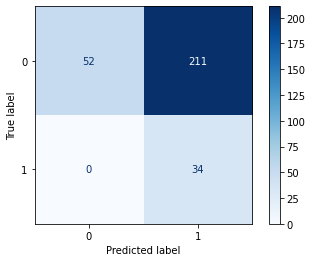

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

label = ["0", "1"]
cm = confusion_matrix(nus1_y_test, y_pred_org)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# **Accuracy**

In [59]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(nus1_X_train, nus1_y_train)
print('NUS1 Data')
print(knn.score(nus1_X_test, nus1_y_test))

#knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(nus1_org_X_train, nus1_org_y_train)
print('Without NUS!')
print(knn.score(nus1_X_test, nus1_y_test))

NUS1 Data
0.7710437710437711
Without NUS!
0.2895622895622896


In [60]:
f1_score(nus1_y_test, y_pred_nus1, average='macro')

0.49821109123434704

In [61]:
f1_score(nus1_y_test, y_pred_nus1, average='micro')

0.7710437710437711

In [62]:
f1_score(nus1_y_test, y_pred_nus1, average='weighted')

0.7835018842770781

In [63]:
f1_score(nus1_y_test, y_pred_nus1, average=None)

array([0.86821705, 0.12820513])

# **Plot Results**

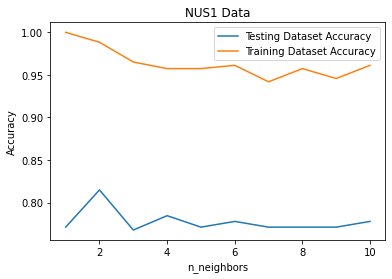

In [64]:
#NUS1 Data
neighbors = np.arange(1,11)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(nus1_X_train, nus1_y_train)
  
  train_accuracy[i] = knn.score(nus1_X_train, nus1_y_train)
  test_accuracy[i] = knn.score(nus1_X_test, nus1_y_test)

plt.plot(neighbors, test_accuracy, label='Testing Dataset Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Dataset Accuracy')

plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('NUS1 Data')
plt.show()

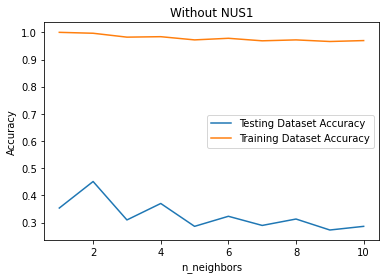

In [65]:
#Original Data (Without NUS1)
neighbors = np.arange(1,11)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(nus1_org_X_train, nus1_org_y_train)
  
  train_accuracy[i] = knn.score(nus1_org_X_train, nus1_org_y_train)
  test_accuracy[i] = knn.score(nus1_X_test, nus1_y_test)

plt.plot(neighbors, test_accuracy, label='Testing Dataset Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Dataset Accuracy')

plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('Without NUS1')
plt.show()